# Binomial Beta model

## Hypothesis

### Hypothesis Bias Against

In [38]:
import numpy as np
from scipy.stats import binom, beta
from scipy.special import logsumexp

def ss_hypothesis_bias_against_binomial_1p(
    n_sample,
    hypothesis,
    n_datasets=1000,
    n_marginal=1000,
    prior_alpha=1,
    prior_beta=1,
    cumulative=False
):
    """
    Calculate the bias against a hypothesis using the sufficient statistic approach for the binomial-beta model.

    Parameters:
    - n_sample (int): Sample size (number of trials) for each dataset.
    - hypothesis (float): The hypothesized value of p (probability of success).
    - n_datasets (int): Number of datasets to simulate.
    - n_marginal (int): Number of samples to estimate the marginal likelihood.
    - prior_alpha (float): Alpha parameter of the Beta prior distribution.
    - prior_beta (float): Beta parameter of the Beta prior distribution.
    - cumulative (bool): Whether to return cumulative bias against values.

    Returns:
    - float or np.ndarray: Final bias against estimate or cumulative bias against values.
    """

    # Step 1: Generate sample totals x from the sampling distribution under the hypothesis
    x = np.random.binomial(n_sample, hypothesis, size=n_datasets)

    # Step 2: Compute the log-likelihood of x under the hypothesis
    log_likelihood = binom.logpmf(x, n_sample, hypothesis)

    # Step 3: Sample p from the prior distribution
    p_samples = np.random.beta(prior_alpha, prior_beta, size=n_marginal)

    # Step 4: Compute the marginal likelihood p(x) via Monte Carlo integration
    # Compute p(x | p) for each p_sample and x
    # Shape of log_likelihoods: (n_datasets, n_marginal)
    log_likelihoods = binom.logpmf(x[:, np.newaxis], n_sample, p_samples[np.newaxis, :])

    # Compute log marginal likelihood for each x using log-sum-exp trick for numerical stability
    log_marginal_likelihood = logsumexp(log_likelihoods, axis=1) - np.log(n_marginal)

    # Step 5: Compute the bias against
    bias_against = (log_likelihood - log_marginal_likelihood) <= 0

    # Compute cumulative bias against if requested
    bias_against_cumsum = np.cumsum(bias_against) / np.arange(1, n_datasets + 1)

    if cumulative:
        return bias_against_cumsum[300:]
    else:
        return bias_against_cumsum[-1]


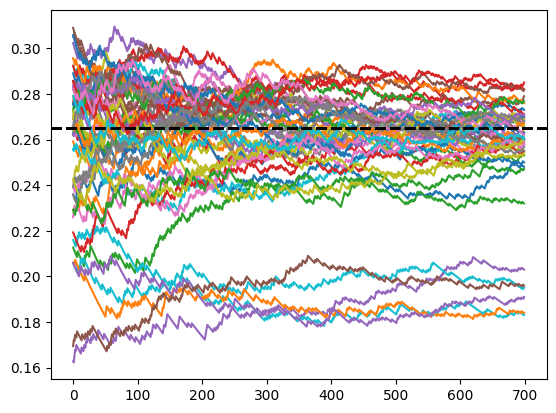

In [93]:
import matplotlib.pyplot as plt
# Parameters
n_sample = 20
hypothesis = 0.5
n_datasets = 1000
n_marginal = 4000
prior_alpha = 4
prior_beta = 4

loops = 50
for i in range(loops):
    # Calculate bias against
    bias_against = ss_hypothesis_bias_against_binomial_1p(
        n_sample,
        hypothesis,
        n_datasets,
        n_marginal,
        prior_alpha,
        prior_beta,
        cumulative=True
        )
    plt.plot(bias_against)
    plt.axhline(y=0.265, color='black', linestyle='--', linewidth=2, label='True value: p = 0.265')


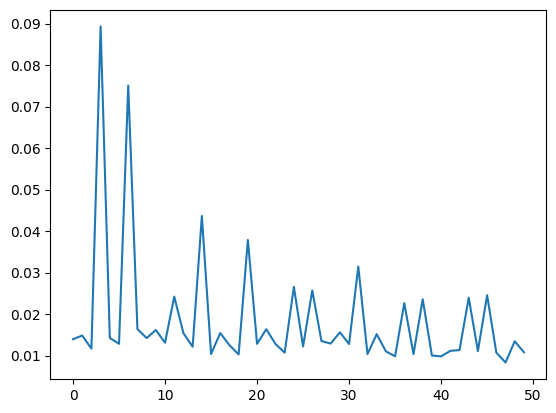

In [50]:
import matplotlib.pyplot as plt
# Parameters
n_sample = 24
hypothesis = 0.5
n_datasets = 1000
n_marginal = 1000
prior_alpha = 4
prior_beta = 4

n_sample = np.linspace(1, 50, 50)
loops = 50
stds = np.zeros(50)
for j in range(50):
    bias_against = np.zeros(loops)
    for i in range(loops):
        # Calculate bias against
        bias_against[i] = ss_hypothesis_bias_against_binomial_1p(
            n_sample[j],
            hypothesis,
            n_datasets,
            n_marginal,
            prior_alpha,
            prior_beta,
            cumulative=False
        )
    stds[j] = np.std(bias_against)
plt.plot(stds)

    


In [51]:
stds

array([0.0139396 , 0.01484108, 0.01168125, 0.08929978, 0.01424484,
       0.01283346, 0.07506623, 0.01637365, 0.01422342, 0.01616229,
       0.01310147, 0.02420652, 0.01539352, 0.01213427, 0.04363645,
       0.01037738, 0.01542549, 0.01251337, 0.01028638, 0.0378641 ,
       0.01282537, 0.01636582, 0.01280327, 0.0107011 , 0.02655108,
       0.01219344, 0.0257017 , 0.01350283, 0.01289496, 0.01560385,
       0.01278787, 0.03145598, 0.01035567, 0.01516306, 0.01102296,
       0.00982448, 0.02264775, 0.01034841, 0.02355993, 0.0100187 ,
       0.00980777, 0.01113749, 0.01133024, 0.02393906, 0.01109133,
       0.02454407, 0.01071634, 0.00833844, 0.01343732, 0.01080378])

n = 1, Probability of bias against: 0.0000
n = 2, Probability of bias against: 0.5000
n = 3, Probability of bias against: 0.2500
n = 4, Probability of bias against: 0.1250
n = 5, Probability of bias against: 0.3750
n = 6, Probability of bias against: 0.2188
n = 7, Probability of bias against: 0.1250
n = 8, Probability of bias against: 0.2891
n = 9, Probability of bias against: 0.1797
n = 10, Probability of bias against: 0.3438
n = 11, Probability of bias against: 0.2266
n = 12, Probability of bias against: 0.1460
n = 13, Probability of bias against: 0.2668
n = 14, Probability of bias against: 0.1796
n = 15, Probability of bias against: 0.3018
n = 16, Probability of bias against: 0.2101
n = 17, Probability of bias against: 0.1435
n = 18, Probability of bias against: 0.2379
n = 19, Probability of bias against: 0.1671
n = 20, Probability of bias against: 0.2632
n = 21, Probability of bias against: 0.1892
n = 22, Probability of bias against: 0.1338
n = 23, Probability of bias against: 0.21

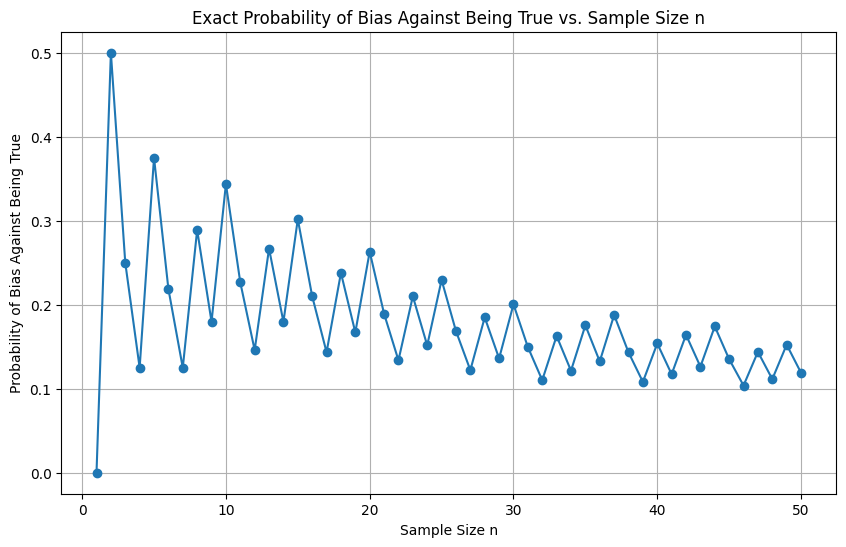

In [68]:
import numpy as np
from scipy.stats import binom, betabinom
from scipy.special import betaln, comb
import matplotlib.pyplot as plt

def compute_exact_bias_against_probabilities(
    n_samples,
    hypothesis,
    prior_alpha=1,
    prior_beta=1
):
    """
    Compute the exact probability of bias against being True as a function of n.

    Parameters:
    - n_samples (list or np.ndarray): List or array of sample sizes (n) to compute.
    - hypothesis (float): The hypothesized value of p (probability of success).
    - prior_alpha (float): Alpha parameter of the Beta prior distribution.
    - prior_beta (float): Beta parameter of the Beta prior distribution.

    Returns:
    - np.ndarray: Array of probabilities of bias against being True for each n.
    """
    probabilities = []

    for n in n_samples:
        # Initialize total probability of bias against being True
        total_bias_against_prob = 0.0

        # Enumerate all possible x from 0 to n
        x_values = np.arange(0, n + 1)

        # Compute log-likelihood under the hypothesis for all x
        log_likelihood = binom.logpmf(x_values, n, hypothesis)

        # Compute the exact log marginal likelihood p(x) using beta-binomial
        # Log of the binomial coefficient
        log_binom_coeff = np.log(comb(n, x_values))
        # Log of the Beta function terms
        log_beta_num = betaln(x_values + prior_alpha, n - x_values + prior_beta)
        log_beta_den = betaln(prior_alpha, prior_beta)
        # Compute log marginal likelihood
        log_marginal_likelihood = log_binom_coeff + log_beta_num - log_beta_den

        # Determine bias against for each x
        bias_against = (log_likelihood - log_marginal_likelihood) <= 0

        # Compute the probability of each x under the hypothesis
        p_x_given_hypothesis = np.exp(log_likelihood)

        # Sum the probabilities where bias against is True
        total_bias_against_prob = np.sum(p_x_given_hypothesis[bias_against])

        probabilities.append(total_bias_against_prob)

    return np.array(probabilities)

# Example usage

# Parameters
n_samples = np.arange(1, 51)  # Sample sizes from 1 to 50
hypothesis = 0.5
prior_alpha = 4
prior_beta = 4

# Compute exact probabilities
exact_probabilities = compute_exact_bias_against_probabilities(
    n_samples,
    hypothesis,
    prior_alpha,
    prior_beta
    )

# Print the probabilities
for n, prob in zip(n_samples, exact_probabilities):
    print(f"n = {n}, Probability of bias against: {prob:.4f}")

    # Plot the probabilities
plt.figure(figsize=(10, 6))
plt.plot(n_samples, exact_probabilities, marker='o')
plt.title('Exact Probability of Bias Against Being True vs. Sample Size n')
plt.xlabel('Sample Size n')
plt.ylabel('Probability of Bias Against Being True')
plt.grid(True)
plt.show()


### Hypothesis Bias in Favor

In [62]:
import numpy as np
from scipy.stats import binom, beta
from scipy.special import logsumexp

def ss_hypothesis_bias_in_favor_binomial_1p(
    n_sample,
    hypothesis,
    delta,
    n_datasets=1000,
    n_marginal=1000,
    prior_alpha=1,
    prior_beta=1,
    cumulative=False
):
    """
    Estimates the bias in favor of a binomial hypothesis using the sufficient statistic approach,
    with Monte Carlo integration for the marginal likelihood.
    
    Parameters:
    ----------
    n_sample : int
        Sample size (number of trials) for each dataset.
    hypothesis : float
        The hypothesized probability of success p₀.
    delta : float
        The specified distance delta (must satisfy 0 < |delta| < min(hypothesis, 1 - hypothesis)).
    n_datasets : int, optional
        Number of datasets (number of sufficient statistics x) to simulate (default is 1000).
    n_marginal : int, optional
        Number of samples to estimate the marginal likelihood (default is 1000).
    prior_alpha : float, optional
        Alpha parameter of the Beta prior distribution (default is 1).
    prior_beta : float, optional
        Beta parameter of the Beta prior distribution (default is 1).
    cumulative : bool, optional
        If True, returns the cumulative bias in favor (default is False).
    
    Returns:
    -------
    float or np.ndarray
        Final bias in favor estimate or cumulative bias in favor values.
    """
    # Initialize lists to store cumulative bias in favor for +delta and -delta shifts
    bias_in_favor_cumsums = []

    # Loop over +delta and -delta shifts
    for shift in [+delta, -delta]:
        # Step 1: Set p = hypothesis + delta or hypothesis - delta
        p = hypothesis + shift
        # Ensure p is within (0,1)
        if p <= 0 or p >= 1:
            raise ValueError("The shifted probability p must be between 0 and 1.")

        # Step 2: Generate sample totals x from p(x | p)
        x = np.random.binomial(n_sample, p, size=n_datasets)

        # Step 3: Compute log-likelihoods of x under the hypothesis
        log_likelihood = binom.logpmf(x, n_sample, hypothesis)

        # Step 4: Sample p_j from the prior distribution
        p_j_samples = np.random.beta(prior_alpha, prior_beta, size=n_marginal)

        # Step 5: Compute the marginal likelihood p(x) via Monte Carlo integration
        # Compute log p(x | p_j) for each p_j and x
        # Shape: (n_datasets, n_marginal)
        log_likelihoods = binom.logpmf(
            x[:, np.newaxis],
            n_sample,
            p_j_samples[np.newaxis, :]
        )

        # Compute log marginal likelihood for each x using log-sum-exp trick
        # log p(x) = log(1/n_marginal * sum_{j} exp(log p(x | p_j)))
        log_marginal_likelihood = logsumexp(log_likelihoods, axis=1) - np.log(n_marginal)

        # Step 6: Compute the log relative belief ratio for each x
        log_rb = log_likelihood - log_marginal_likelihood

        # Step 7: Determine bias in favor: RB(hypothesis | x) > 1 (i.e., log_rb > 0)
        bias_in_favor = (log_rb > 0).astype(int)

        # Step 8: Calculate cumulative bias in favor (running mean)
        bias_in_favor_cumsum = np.cumsum(bias_in_favor) / np.arange(1, len(bias_in_favor) + 1)
        bias_in_favor_cumsums.append(bias_in_favor_cumsum)

    # Step 9: Compare the cumulative bias for +delta and -delta, and choose the one with higher final cumulative bias
    final_bias_cumsum = max(bias_in_favor_cumsums, key=lambda x: x[-1])

    # Return cumulative bias if `cumulative=True`, otherwise return the final bias value
    if cumulative:
        return final_bias_cumsum[300:]
    else:
        return final_bias_cumsum[-1]


In [71]:
import numpy as np
from scipy.stats import binom, beta
from scipy.special import betaln, comb, logsumexp

def ss_hypothesis_bias_in_favor_binomial_1p_2(
    n_sample,
    hypothesis,
    delta,
    n_datasets=1000,
    prior_alpha=1,
    prior_beta=1,
    cumulative=False
):
    """
    Estimates the bias in favor of a binomial hypothesis using the sufficient statistic approach.
    
    Parameters:
    ----------
    n_sample : int
        Sample size (number of trials) for each dataset.
    hypothesis : float
        The hypothesized probability of success p₀.
    delta : float
        The specified distance delta (must be between 0 and 1 - hypothesis).
    n_datasets : int, optional
        Number of datasets (number of sufficient statistics x) to simulate (default is 1000).
    prior_alpha : float, optional
        Alpha parameter of the Beta prior distribution (default is 1).
    prior_beta : float, optional
        Beta parameter of the Beta prior distribution (default is 1).
    cumulative : bool, optional
        If True, returns the cumulative bias in favor (default is False).
    
    Returns:
    -------
    float or np.ndarray
        Final bias in favor estimate or cumulative bias in favor values.
    """
    # Initialize lists to store cumulative bias in favor for +delta and -delta shifts
    bias_in_favor_cumsums = []
    
    # Loop over +delta and -delta shifts
    for shift in [+delta, -delta]:
        # Step 1: Set p = hypothesis + delta or hypothesis - delta
        p = hypothesis + shift
        # Ensure p is within (0,1)
        if p <= 0 or p >= 1:
            raise ValueError("The shifted probability p must be between 0 and 1.")
        
        # Step 2: Generate sample totals x from p(x | p)
        x = np.random.binomial(n_sample, p, size=n_datasets)
        
        # Step 3: Compute log-likelihoods of x under the hypothesis
        log_likelihood = binom.logpmf(x, n_sample, hypothesis)
        
        # Step 4: Compute the exact log marginal likelihood p(x)
        # Log of the binomial coefficient
        log_binom_coeff = np.log(comb(n_sample, x))
        
        # Log of the Beta function terms
        log_beta_num = betaln(x + prior_alpha, n_sample - x + prior_beta)
        log_beta_den = betaln(prior_alpha, prior_beta)
        
        # Compute log marginal likelihood
        log_marginal_likelihood = log_binom_coeff + log_beta_num - log_beta_den
        
        # Step 5: Compute the log relative belief ratio for each x
        log_rb = log_likelihood - log_marginal_likelihood
        
        # Step 6: Determine bias in favor: RB(hypothesis | x) > 1 (i.e., log_rb > 0)
        bias_in_favor = (log_rb > 0).astype(int)
        
        # Step 7: Calculate cumulative bias in favor (running mean)
        bias_in_favor_cumsum = np.cumsum(bias_in_favor) / np.arange(1, len(bias_in_favor) + 1)
        bias_in_favor_cumsums.append(bias_in_favor_cumsum)
    
    # Step 8: Compare the cumulative bias for +delta and -delta, and choose the one with higher final cumulative bias
    final_bias_cumsum = max(bias_in_favor_cumsums, key=lambda x: x[-1])
    
    # Return cumulative bias if `cumulative=True`, otherwise return the final bias value
    if cumulative:
        return final_bias_cumsum[300:]
    else:
        return final_bias_cumsum[-1]


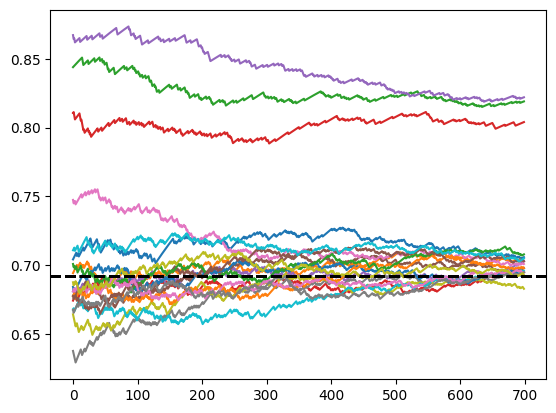

In [88]:
# Parameters
n_sample = 20
hypothesis = 0.5
delta = 0.05
n_datasets = 1000
n_marginal = 4000
prior_alpha = 4
prior_beta = 4

loops = 20
for i in range(loops):
    # Calculate bias against
    bias_in_favor = ss_hypothesis_bias_in_favor_binomial_1p(
        n_sample,
        hypothesis,
        delta,
        n_datasets,
        n_marginal,
        prior_alpha,
        prior_beta,
        cumulative=True
        )
    plt.plot(bias_in_favor)
    plt.axhline(y=0.692, color='black', linestyle='--', linewidth=2, label='True value: p = 0.692')



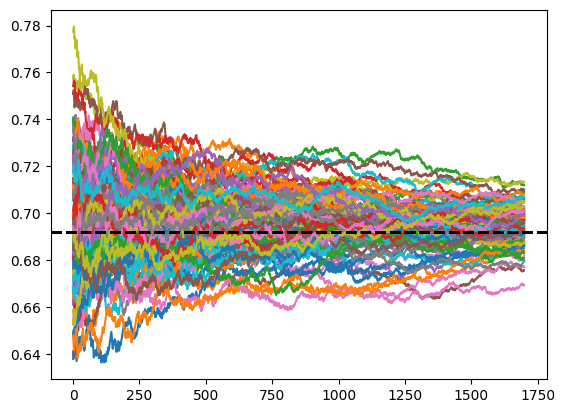

In [85]:
# Parameters
n_sample = 20
hypothesis = 0.5
delta = 0.05
n_datasets = 2000
prior_alpha = 4
prior_beta = 4

loops = 100
for i in range(loops):
    # Calculate bias against
    bias_in_favor = ss_hypothesis_bias_in_favor_binomial_1p_2(
        n_sample,
        hypothesis,
        delta,
        n_datasets,
        prior_alpha,
        prior_beta,
        cumulative=True
        )
    plt.plot(bias_in_favor)
    plt.axhline(y=0.692, color='black', linestyle='--', linewidth=2, label='True value: p = 0.692')



n = 1, Probability of bias in favor: 1.0000
n = 2, Probability of bias in favor: 0.4950
n = 3, Probability of bias in favor: 0.7425
n = 4, Probability of bias in favor: 0.8675
n = 5, Probability of bias in favor: 0.6126
n = 6, Probability of bias in favor: 0.7672
n = 7, Probability of bias in favor: 0.8619
n = 8, Probability of bias in favor: 0.6914
n = 9, Probability of bias in favor: 0.8007
n = 10, Probability of bias in favor: 0.6320
n = 11, Probability of bias in favor: 0.7479
n = 12, Probability of bias in favor: 0.8300
n = 13, Probability of bias in favor: 0.7022
n = 14, Probability of bias in favor: 0.7902
n = 15, Probability of bias in favor: 0.6623
n = 16, Probability of bias in favor: 0.7538
n = 17, Probability of bias in favor: 0.8228
n = 18, Probability of bias in favor: 0.7205
n = 19, Probability of bias in favor: 0.7931
n = 20, Probability of bias in favor: 0.6900
n = 21, Probability of bias in favor: 0.7650
n = 22, Probability of bias in favor: 0.8239
n = 23, Probability

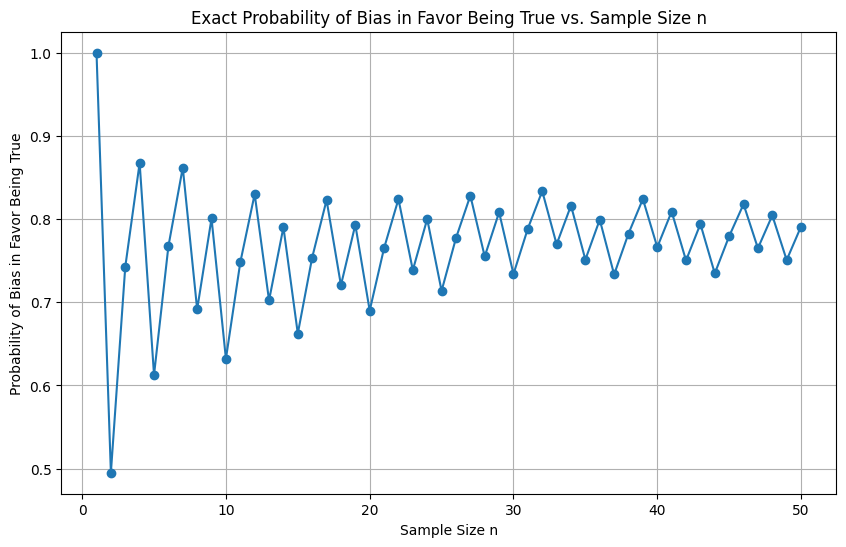

In [67]:
import numpy as np
from scipy.stats import binom
from scipy.special import betaln, comb
import matplotlib.pyplot as plt

def compute_exact_bias_in_favor_probabilities(
    n_samples,
    hypothesis,
    delta,
    prior_alpha=1,
    prior_beta=1
):
    """
    Compute the exact probability of bias in favor being True as a function of n.

    Parameters:
    - n_samples (list or np.ndarray): List or array of sample sizes (n) to compute.
    - hypothesis (float): The hypothesized value of p (probability of success).
    - delta (float): The specified distance delta (should be 0 < delta < min(hypothesis, 1 - hypothesis)).
    - prior_alpha (float): Alpha parameter of the Beta prior distribution.
    - prior_beta (float): Beta parameter of the Beta prior distribution.

    Returns:
    - np.ndarray: Array of probabilities of bias in favor being True for each n.
    """
    probabilities = []

    for n in n_samples:
        # Initialize list to store total bias in favor probabilities for +delta and -delta
        total_bias_in_favor_probs = []

        # Loop over +delta and -delta shifts
        for shift in [+delta, -delta]:
            p_shifted = hypothesis + shift
            # Ensure p_shifted is within (0,1)
            if p_shifted <= 0 or p_shifted >= 1:
                # If p_shifted is invalid, skip this shift
                continue

            # Enumerate all possible x from 0 to n
            x_values = np.arange(0, n + 1)

            # Compute log-likelihood under the hypothesis for all x
            log_likelihood = binom.logpmf(x_values, n, hypothesis)

            # Compute the exact log marginal likelihood p(x)
            # Log of the binomial coefficient
            log_binom_coeff = np.log(comb(n, x_values))
            # Log of the Beta function terms
            log_beta_num = betaln(x_values + prior_alpha, n - x_values + prior_beta)
            log_beta_den = betaln(prior_alpha, prior_beta)
            # Compute log marginal likelihood
            log_marginal_likelihood = log_binom_coeff + log_beta_num - log_beta_den

            # Compute log relative belief ratio
            log_rb = log_likelihood - log_marginal_likelihood

            # Determine bias in favor: log_rb > 0
            bias_in_favor = (log_rb > 0)

            # Compute the probability of each x under the shifted p
            p_x_given_shifted = np.exp(binom.logpmf(x_values, n, p_shifted))

            # Sum the probabilities where bias in favor is True
            total_bias_in_favor_prob = np.sum(p_x_given_shifted[bias_in_favor])

            total_bias_in_favor_probs.append(total_bias_in_favor_prob)

        # If both shifts are valid, take the maximum probability
        if total_bias_in_favor_probs:
            max_bias_in_favor_prob = max(total_bias_in_favor_probs)
        else:
            # If both shifts are invalid (due to p_shifted out of bounds), set probability to NaN
            max_bias_in_favor_prob = np.nan

        probabilities.append(max_bias_in_favor_prob)

    return np.array(probabilities)

# Example usage
# Parameters
n_samples = np.arange(1, 51)  # Sample sizes from 1 to 50
hypothesis = 0.5
delta = 0.05
prior_alpha = 4
prior_beta = 4

# Compute exact probabilities
exact_probabilities = compute_exact_bias_in_favor_probabilities(
    n_samples,
    hypothesis,
    delta,
    prior_alpha,
    prior_beta
)

# Print the probabilities
for n, prob in zip(n_samples, exact_probabilities):
    print(f"n = {n}, Probability of bias in favor: {prob:.4f}")

# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.plot(n_samples, exact_probabilities, marker='o')
plt.title('Exact Probability of Bias in Favor Being True vs. Sample Size n')
plt.xlabel('Sample Size n')
plt.ylabel('Probability of Bias in Favor Being True')
plt.grid(True)
plt.show()


In [96]:
import numpy as np
from scipy.stats import binom, beta
from scipy.special import logsumexp

def ss_estimation_bias_against_binomial_1p(
    n_sample,
    n_datasets=1000,
    n_marginal=1000,
    prior_alpha=1,
    prior_beta=1,
    cumulative=False
):
    """
    Estimates the bias against a binomial parameter estimate using sufficient statistics.

    Parameters:
    ----------
    n_sample : int
        Sample size (number of trials) for each dataset.
    n_datasets : int, optional
        Number of datasets (number of sufficient statistics x) to simulate (default is 1000).
    n_marginal : int, optional
        Number of samples to estimate the marginal likelihood (default is 1000).
    prior_alpha : float, optional
        Alpha parameter of the Beta prior distribution (default is 1).
    prior_beta : float, optional
        Beta parameter of the Beta prior distribution (default is 1).
    cumulative : bool, optional
        If True, returns the cumulative bias against values (default is False).

    Returns:
    -------
    float or np.ndarray
        Final bias against estimate or cumulative bias against values.
    """

    # Step 1: Sample p₀ from the prior distribution
    p0_samples = np.random.beta(prior_alpha, prior_beta, size=n_datasets)
    
    # Step 2: Generate x from p(x | p₀)
    x = np.random.binomial(n_sample, p0_samples)
    
    # Step 3: Compute log-likelihoods of x under p₀
    log_likelihood = binom.logpmf(x, n_sample, p0_samples)
    
    # Step 4: Sample p_j from the prior distribution
    p_j_samples = np.random.beta(prior_alpha, prior_beta, size=n_marginal)
    
    # Step 5: Compute the marginal likelihood p(x) via Monte Carlo integration
    # Compute log p(x | p_j) for each p_j and x
    # Shape: (n_datasets, n_marginal)
    log_likelihoods = binom.logpmf(
        x[:, np.newaxis],
        n_sample,
        p_j_samples[np.newaxis, :]
    )
    
    # Compute log marginal likelihood for each x using log-sum-exp trick
    # log p(x) = log(1/n_marginal * sum_{j} exp(log p(x | p_j)))
    log_marginal_likelihood = logsumexp(log_likelihoods, axis=1) - np.log(n_marginal)
    
    # Step 6: Compute the bias against
    bias_against = (log_likelihood - log_marginal_likelihood) <= 0
    
    # Compute cumulative bias against if requested
    bias_against_cumsum = np.cumsum(bias_against) / np.arange(1, n_datasets + 1)
    
    if cumulative:
        return bias_against_cumsum[300:]
    else:
        return bias_against_cumsum[-1]


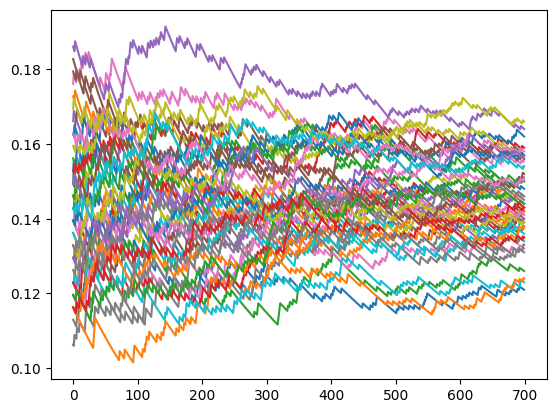

In [97]:
import matplotlib.pyplot as plt
# Parameters
n_sample = 20
n_datasets = 1000
n_marginal = 4000
prior_alpha = 4
prior_beta = 4

loops = 50
for i in range(loops):
    # Calculate bias against
    bias_against = ss_estimation_bias_against_binomial_1p(
        n_sample,
        n_datasets,
        n_marginal,
        prior_alpha,
        prior_beta,
        cumulative=True
        )
    plt.plot(bias_against)


In [98]:
import numpy as np
from scipy.stats import binom, beta
from scipy.special import logsumexp

def ss_estimation_bias_in_favor_binomial_1p(
    n_sample,      # Number of trials in each dataset x
    delta,         # The distance delta
    n_iter=50,     # Number of iterations over p₀
    prior_alpha=1, # Alpha parameter of the Beta prior
    prior_beta=1,  # Beta parameter of the Beta prior
    n_marginal=500,  # Number of samples to estimate p(x)
    n_datasets=50,    # Number of datasets per p
    cumulative=False  # Return cumulative bias if True, otherwise return the final bias value
):
    """
    Estimates bias in favor of a binomial parameter estimate using sufficient statistics.
    """

    # Step 1: Pre-sample all p₀ values from the prior distribution
    p0_samples = np.random.beta(prior_alpha, prior_beta, size=n_iter)
    
    # Step 2: Pre-sample p_j_samples for marginal likelihood estimation
    p_j_samples = np.random.beta(prior_alpha, prior_beta, size=n_marginal)
    
    # Initialize an array to store the maximum biases from each iteration
    max_biases = np.zeros(n_iter)
    
    for i, p0 in enumerate(p0_samples):
        # Array to store biases for p = p₀ + delta and p₀ - delta
        biases = []
        
        for delta_sign in [+delta, -delta]:
            # Step 3: Set p = p₀ + delta or p₀ - delta
            p = p0 + delta_sign
            # Ensure p is within (0,1)
            if p <= 0 or p >= 1:
                # Skip this delta_sign if p is out of bounds
                continue
            
            # Step 4: Generate x from p(x | p)
            # x shape: (n_datasets,)
            x = np.random.binomial(n_sample, p, size=n_datasets)
            
            # Step 5: Compute log p(x | p₀) for each dataset
            # log_p_x_given_p0 shape: (n_datasets,)
            log_p_x_given_p0 = binom.logpmf(x, n_sample, p0)
            
            # Step 6: Estimate log p(x) via Monte Carlo integration
            # Compute log p(x | p_j) for all p_j and datasets
            # log_p_x_given_p_j shape: (n_datasets, n_marginal)
            x_expanded = x[:, np.newaxis]  # Shape: (n_datasets, 1)
            p_j_expanded = p_j_samples[np.newaxis, :]  # Shape: (1, n_marginal)
            
            log_p_x_given_p_j = binom.logpmf(x_expanded, n_sample, p_j_expanded)
            
            # Compute log p(x) for each dataset
            # log_p_x shape: (n_datasets,)
            log_p_x = logsumexp(log_p_x_given_p_j, axis=1) - np.log(n_marginal)
            
            # Step 7: Compute the log relative belief ratio for each dataset
            log_rb = log_p_x_given_p0 - log_p_x
            
            # Step 8: Determine bias for each dataset
            biases_datasets = (log_rb > 0).astype(int)
            
            # Step 9: Compute the bias for this p as the mean over datasets
            bias = biases_datasets.mean()
            
            # Store the bias for this delta sign
            biases.append(bias)
        
        if biases:
            # Step 10: Store the maximum of the biases (if any valid delta_sign)
            max_biases[i] = max(biases)
        else:
            # If both delta_signs were invalid (p out of bounds), store NaN
            max_biases[i] = np.nan
    
    # Remove NaN values from max_biases
    valid_max_biases = max_biases[~np.isnan(max_biases)]
    
    # Step 11: Compute the final bias in favor estimate
    bias_in_favor_estimate = valid_max_biases.mean()
    
    # Return cumulative bias if `cumulative=True`, otherwise return the final bias value
    if cumulative:
        # Compute cumulative mean over valid_max_biases
        cumulative_bias = np.cumsum(valid_max_biases) / np.arange(1, len(valid_max_biases) + 1)
        return cumulative_bias
    else:
        return bias_in_favor_estimate


In [115]:
# Parameters
n_sample = 100
delta = 0.05
n_iter = 100
prior_alpha = 4
prior_beta = 4
n_marginal = 1000
n_datasets = 100

# Calculate bias in favor
bias_in_favor = ss_estimation_bias_in_favor_binomial_1p(
    n_sample,
    delta,
    n_iter=n_iter,
    prior_alpha=prior_alpha,
    prior_beta=prior_beta,
    n_marginal=n_marginal,
    n_datasets=n_datasets,
    cumulative=False
)

print(f"Bias in favor of the estimated p₀: {bias_in_favor }")


Bias in favor of the estimated p₀: 0.49010000000000004
